In [29]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Input,Flatten,Concatenate,Lambda
from keras.layers import Conv2D,Conv2DTranspose,MaxPooling2D
from keras.layers import Dropout,Dense
from keras.models import Model
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

In [3]:
img_width=128
img_height=128
img_channels=3

In [19]:
train_path='C:/Users/nikhi/Downloads/stage1_train/'
test_path='C:/Users/nikhi/Downloads/stage1_test/'

In [24]:
train_ids=next(os.walk(train_path))[1]
test_ids=next(os.walk(test_path))[1]

In [26]:
X_train=np.zeros((len(train_ids),img_height,img_width,img_channels),dtype=np.uint8)
y_train=np.zeros((len(train_ids),img_height,img_width,1),dtype=np.bool_)

In [35]:
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path=train_path+id_
    img=imread(path+'/images/'+id_+'.png')[:,:,:img_channels]
    img=resize(img,(img_height,img_width),mode='constant',preserve_range=True)
    X_train[n]=img
    
    mask=np.zeros((img_height,img_width,1),dtype=np.bool_)
    
    for mask_file in next(os.walk(path+'/masks/'))[2]:
        mask_=imread(path+'/masks/'+mask_file)
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant',preserve_range=True), axis=-1)
        mask=np.maximum(mask,mask_)
        
    y_train[n]=mask

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [06:09<00:00,  1.81it/s]


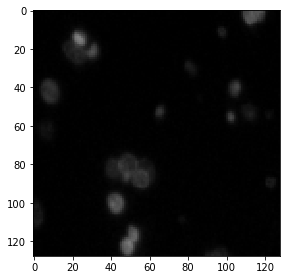

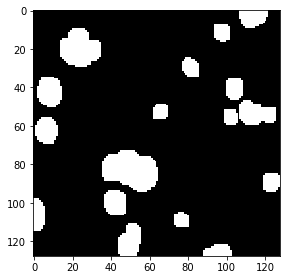

In [39]:
image_x=np.random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()

imshow(np.squeeze(y_train[image_x]))
plt.show()

In [40]:
X_test=np.zeros((len(test_ids),img_height,img_width,img_channels),dtype=np.uint8)

for n,id_ in tqdm(enumerate(test_ids),total=len(test_ids)):
    path=test_path+id_
    img=imread(path+'/images/'+id_+'.png')[:,:,:img_channels]
    img=resize(img,(img_height,img_width),mode='constant',preserve_range=True)
    X_test[n]=img

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 49.13it/s]


In [15]:
inputs=Input((img_height,img_width,img_channels))
s=Lambda(lambda x:x/255)(inputs)

# Contraction path

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 =MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 =Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive Path

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = Concatenate()([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = Concatenate()([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = Concatenate()([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 =Concatenate(axis=3)([u9, c1])
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [17]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_7 (Lambda)              (None, 128, 128, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv2d_50 (Conv2D)             (None, 128, 128, 16  448         ['lambda_7[0][0]']               
                                )                                                                 
                                                                                              

In [47]:
checkpointer=keras.callbacks.ModelCheckpoint('model_for_nuclei.h5',verbose=1,save_best_only=True)

callbacks=[keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
          keras.callbacks.TensorBoard(log_dir='logs')]

results=model.fit(X_train,y_train,validation_split=0.1,batch_size=16,epochs=3,callbacks=callbacks)

Epoch 1/3
38/38 [==============================] - 27s 694ms/step - loss: 0.5264 - accuracy: 0.7508 - val_loss: 0.2635 - val_accuracy: 0.8600
Epoch 2/3
38/38 [==============================] - 32s 854ms/step - loss: 0.2709 - accuracy: 0.8796 - val_loss: 0.1955 - val_accuracy: 0.9240
Epoch 3/3
38/38 [==============================] - 35s 925ms/step - loss: 0.1782 - accuracy: 0.9332 - val_loss: 0.1415 - val_accuracy: 0.9460


In [52]:
pred=model.predict(X_test,verbose=1)

3/3 [==============================] - 1s 115ms/step


In [56]:
predicted=(pred>0.5).astype('uint8')

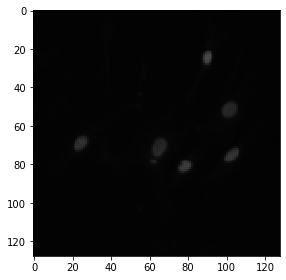

In [63]:
imshow(X_test[0])

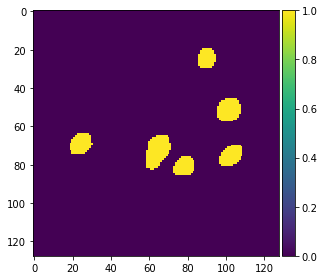

In [62]:
imshow(predicted[0])